In [1]:
import os
import glob
import torch
from torch import nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from ast import literal_eval
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools
import random
import seaborn as sns
from sklearn.metrics import confusion_matrix
import subprocess
import torch.nn.functional as F
import gc

In [2]:
def select_least_used_gpu():
    result = subprocess.run(['nvidia-smi', '--query-gpu=memory.used,memory.total', '--format=csv,nounits,noheader'], stdout=subprocess.PIPE)
    output = result.stdout.decode('utf-8').strip()
    gpu_info = output.split('\n')
    gpu_memory = []
    for info in gpu_info:
        memory_used, memory_total = map(int, info.split(','))
        gpu_memory.append(memory_used)

    # Get the index of the GPU with the least memory usage
    gpu_index = np.argmin(gpu_memory)
    print('Using GPU %d' % gpu_index)
    torch.cuda.set_device(int(gpu_index))

    return torch.device('cuda:' + str(gpu_index))

device = select_least_used_gpu()

Using GPU 0


In [38]:
class SequenceDataset(Dataset):
    def __init__(self, csv_file, root_dir, rmsd_threshold, transform=None):
        self.labels = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.rmsd_threshold = rmsd_threshold
        self.transform = transform
    
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        feature_file = str(self.labels.iloc[idx, 0]).replace('embeddings', 'query_col_attentions').replace('.pt', '_128.pt') 
        feature_path = os.path.join(self.root_dir, feature_file)
        # Test if the path exists
        if not os.path.exists(feature_path):
            print('File %s does not exist' % feature_path)
            return None
        X = torch.load(feature_path)[0,:,:]
        X = torch.from_numpy(X)
        # Pad the sequence to 401 columns
        X = F.pad(X, (0, 0, 0, 401 - X.shape[1]), 'constant', 0)
        y = torch.FloatTensor([float(label) for label in literal_eval(str(self.labels.iloc[idx, 1]))])
        rmsd = y.clone()
        y = F.pad(y, (0, 400 - y.shape[0]), 'constant', 0)
        rmsd = F.pad(rmsd, (0, 400 - rmsd.shape[0]), 'constant', -1)
        for i in range(len(y)):
            y[i] = int(y[i] >= self.rmsd_threshold)
        if self.transform:
            X = self.transform(X)
        return X, y, rmsd, str(self.labels.iloc[idx, 0])

In [158]:
class SequenceDataset(Dataset):
    def __init__(self, csv_file, root_dir, rmsd_threshold, transform=None):
        self.files = glob.glob(os.path.join(root_dir, '*.pt'))
        self.labels = pd.read_csv(csv_file)
        self.embeddings = self.labels.iloc[:, 0]
        self.root_dir = root_dir
        self.rmsd_threshold = rmsd_threshold
        self.transform = transform
    
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        #feature_file = str(self.labels.iloc[idx, 0]).replace('embeddings', 'query_col_attentions').replace('.pt', '_128.pt') 
        #feature_path = os.path.join(self.root_dir, feature_file)
        print(len(self.files))
        print(idx)
        
        feature_path = self.files[idx]
        label_name = feature_path.replace('query_col_attentions', 'embeddings').replace('_128.pt', '.pt').split('/')[-1]
        print(label_name)
        label_idx = self.embeddings[self.embeddings == label_name].index[0]
        X = torch.load(feature_path)[0,:,:]
        X = torch.from_numpy(X)
        # Pad the sequence to 401 columns
        X = F.pad(X, (0, 0, 0, 401 - X.shape[1]), 'constant', 0)
        y = torch.FloatTensor([float(label) for label in literal_eval(str(self.labels.iloc[label_idx, 1]))])
        rmsd = y.clone()
        y = F.pad(y, (0, 400 - y.shape[0]), 'constant', 0)
        rmsd = F.pad(rmsd, (0, 400 - rmsd.shape[0]), 'constant', -1)
        for i in range(len(y)):
            y[i] = int(y[i] >= self.rmsd_threshold)
        if self.transform:
            X = self.transform(X)
        return X, y, rmsd, str(self.labels.iloc[label_idx, 0])

In [29]:
CSV_FILE = '/home/vera/projects/masters_project/data/old_rmsd_dataset.csv'
# load csv
labels = pd.read_csv(CSV_FILE)

# print the first column
embeddings = labels.iloc[:, 0]

for i in range(5):
    print(embeddings[i])

embeddings_3ur1_c.pt
embeddings_4kmu_a.pt
embeddings_4q9u_a.pt
embeddings_5b0o_g.pt
embeddings_4nzd_a.pt


In [36]:
CSV_FILE = '/home/vera/projects/masters_project/data/old_rmsd_dataset.csv'
# load csv
labels = pd.read_csv(CSV_FILE)

# print the first column
embeddings = labels.iloc[:, 0]

# Find the index of embeddings_4xs5_c.pt in the embeddings

files = glob.glob(os.path.join('/home/vera/projects/masters_project/data/query_col_attentions/', '*_128.pt'))
print(len(files))
print(len(labels))
for i in range(len(labels)-1, 0, -1):
    label = labels.iloc[i, 0]
    ex_file = label.replace('embeddings', '/home/vera/projects/masters_project/data/query_col_attentions/query_col_attentions').replace('.pt', '_128.pt')
    if not ex_file in files:
        # Drop the row with index i from labels
        labels = labels.drop(labels.index[i])

print(len(labels))

# Save the new labels to a csv file
labels.to_csv('/home/vera/projects/masters_project/data/rmsd_dataset.csv', index=False)

5633
10380
/home/vera/projects/masters_project/data/query_col_attentions/query_col_attentions_1m8v_a_128.pt
/home/vera/projects/masters_project/data/query_col_attentions/query_col_attentions_4xs5_c_128.pt
/home/vera/projects/masters_project/data/query_col_attentions/query_col_attentions_1eyg_a_128.pt
/home/vera/projects/masters_project/data/query_col_attentions/query_col_attentions_3fcg_a_128.pt
/home/vera/projects/masters_project/data/query_col_attentions/query_col_attentions_3tix_a_128.pt
/home/vera/projects/masters_project/data/query_col_attentions/query_col_attentions_1eyv_b_128.pt
/home/vera/projects/masters_project/data/query_col_attentions/query_col_attentions_4wyu_a_128.pt
/home/vera/projects/masters_project/data/query_col_attentions/query_col_attentions_6hn7_a_128.pt
/home/vera/projects/masters_project/data/query_col_attentions/query_col_attentions_2q5w_e_128.pt
/home/vera/projects/masters_project/data/query_col_attentions/query_col_attentions_6f7t_b_128.pt
/home/vera/projects

In [39]:
def create_datasets(csv_file, root_dir, dataset_size, rmsd_threshold):
    sequence_dataset = SequenceDataset(csv_file=csv_file, root_dir=root_dir, rmsd_threshold=rmsd_threshold)
    indices = np.random.choice(len(sequence_dataset), dataset_size, replace=False)
    sequence_dataset = torch.utils.data.Subset(sequence_dataset, indices)

    train_size = int(0.75 * len(sequence_dataset))
    val_size = int(0.125 * len(sequence_dataset))
    test_size = len(sequence_dataset) - train_size - val_size
    train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(sequence_dataset, [train_size, val_size, test_size])

    return train_dataset, val_dataset, test_dataset

In [40]:
def semi_sort_dataset(data, batch_size, shuffle=True):
    # Sort sequences by length
    data = sorted(data, key=lambda x: x[0].shape[1], reverse=True)

    # Shuffle every n*batch_size sequences to avoid having sequences of the same length in the same batch
    shuffle_length = batch_size * 2
    if shuffle:
        for i in range(0, len(data)-shuffle_length, shuffle_length):
            shuffle_batch = data[i:i+shuffle_length]
            random.shuffle(shuffle_batch)
            data[i:i+shuffle_length] = shuffle_batch

    print("Shuffled dataset")
    # For every n:th sequence, where n is the batch size, pad the sequence to be as long as the longest sequence in the batch
    # This is done to avoid having to pad every sequence to the same length, which would result in a lot of unnecessary padding
    batches = []
    for i in range(0, len(data), batch_size):
        batch = data[i:i+batch_size]
        max_len = batch[0][0].shape[1]
        batch_list = []
        for item in batch:
            X = torch.from_numpy(item[0].numpy())
            X = F.pad(X, (0, 0, 0, max_len-X.shape[1]), "constant", 0)
            #X = F.pad(item[0], (0, 0, 0, max_len-item[0].shape[1]), "constant", 0)
            
            y = F.pad(item[1], (0, max_len-item[1].shape[0]), "constant", 0)
            batch_list.append((X, y))
        batches.append(batch_list)
        gc.collect()

    # Shuffle the batches 
    random.shuffle(batches)

    # Put the batches back together
    data = [item for sublist in batches for item in sublist]
    batches = []

    return data

In [51]:
train_dataset = semi_sort_dataset(train_dataset, BATCH_SIZE)

Shuffled dataset


In [48]:
DATASET_SIZE = 256
BATCH_SIZE = 32
RMSD_THRESHOLD = 0.2
CSV_FILE = '/home/vera/projects/masters_project/data/rmsd_dataset.csv'
ROOT_DIR = '/home/vera/projects/masters_project/data/query_col_attentions/'


train_dataset, val_dataset, test_dataset = create_datasets(CSV_FILE, ROOT_DIR, DATASET_SIZE, RMSD_THRESHOLD)

# # Semi-sort the datasets
# train_dataset = semi_sort_dataset(train_dataset, BATCH_SIZE)
# val_dataset = semi_sort_dataset(val_dataset, BATCH_SIZE)
# test_dataset = semi_sort_dataset(test_dataset, BATCH_SIZE)


print("Train dataset size:", len(train_dataset))
print("Validation dataset size:", len(val_dataset))
print("Test dataset size:", len(test_dataset))
random_sample = random.randint(0, len(train_dataset))
print("Random sample from dataset:", train_dataset[random_sample][0].shape, train_dataset[random_sample][1].shape, train_dataset[random_sample][3])
print(train_dataset[random_sample][1][:20])


# Create the dataloaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)


Train dataset size: 192
Validation dataset size: 32
Test dataset size: 32
Random sample from dataset: torch.Size([303, 226]) torch.Size([400]) embeddings_6mtp_h.pt
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])


In [43]:
# Define the model
# Input dimensions: (seq_len, 128, 144)
# Output dimensions: (seq_len, 1, 1)
class SimpleConvNet(nn.Module):
    def __init__(self):
        super(SimpleConvNet, self).__init__()
        
        # 2D Convolutional layers to reduce the dimensions to (seq_len, 1, 1152)
        self.conv1 = nn.Conv2d(144, 288, kernel_size=(5,5), stride=(1,2), padding=2) # 5 * 5 * 144 * 288 ≈ 1.0 M
        self.relu1 = nn.ReLU()
        self.maxpool1 = nn.MaxPool2d(kernel_size=(1,2), stride=(1,2))
        self.conv2 = nn.Conv2d(288, 576, kernel_size=(5,5), stride=(1,2), padding=2) # 5 * 5 * 288 * 576 ≈ 4.1 M
        self.relu2 = nn.ReLU()
        self.maxpool2 = nn.MaxPool2d(kernel_size=(1,2), stride=(1,2))
        self.conv3 = nn.Conv2d(576, 576, kernel_size=(3,3), stride=(1,1), padding=1) # 3 * 3 * 576 * 576 ≈ 3.0 M
        self.relu3 = nn.ReLU()
        self.maxpool3 = nn.MaxPool2d(kernel_size=(1,2), stride=(1,2))
        self.conv4 = nn.Conv2d(576, 1152, kernel_size=(3,3), stride=(1,3), padding=1) # 3 * 3 * 576 * 1152 ≈ 6.0 M
        self.relu4 = nn.ReLU()
        self.maxpool4 = nn.MaxPool2d(kernel_size=(1,2), stride=(1,2))

        # 1D Convolutional layers to reduce the dimensions to (seq_len, 1, 1)
        self.conv5 = nn.Conv1d(1152, 384, kernel_size=1, stride=1, padding=0)
        self.relu5 = nn.ReLU()
        self.conv6 = nn.Conv1d(384, 64, kernel_size=1, stride=1, padding=0)
        self.relu6 = nn.ReLU()
        self.conv7 = nn.Conv1d(64, 1, kernel_size=1, stride=1, padding=0)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # 2D Convolutional layers
        x = self.conv1(self.relu1(x))
        x = self.maxpool1(x)
        x = self.conv2(self.relu2(x))
        x = self.maxpool2(x)
        x = self.conv3(self.relu3(x))
        x = self.maxpool3(x)
        x = self.conv4(self.relu4(x))
        x = self.maxpool4(x)

        # 1D Convolutional layers
        x = x.squeeze(3)
        x = self.conv5(self.relu5(x))
        x = self.conv6(self.relu6(x))
        x = self.conv7(self.sigmoid(x))
        x = x.squeeze(1)
        x = x[:, 1:]

        return x


model = SimpleConvNet()

# Print the parameter count of the model amd each layer
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print("Number of parameters:", f'{count_parameters(model):,}')

Number of parameters: 14,612,001


In [44]:
# Define the model
# Input dimensions: (seq_len, 128, 144)
# Output dimensions: (seq_len, 1, 1)
class SmallerConvNet(nn.Module):
    def __init__(self):
        super(SmallerConvNet, self).__init__()
        
        # 2D Convolutional layers to reduce the dimensions to (seq_len, 1, 1152)
        self.conv1 = nn.Conv2d(144, 144, kernel_size=(3,3), stride=(1,1), padding=1) # 3 * 3 * 144 * 144 ≈ 0.2 M
        self.batchnorm1 = nn.BatchNorm2d(144)
        self.relu1 = nn.ReLU()
        self.maxpool1 = nn.MaxPool2d(kernel_size=(1,2), stride=(1,2))
        self.conv2 = nn.Conv2d(144, 216, kernel_size=(5,5), stride=(1,4), padding=(2,1)) # 5 * 5 * 144 * 216 ≈ 0.8 M
        self.batchnorm2 = nn.BatchNorm2d(216)
        self.relu2 = nn.ReLU()
        self.maxpool2 = nn.MaxPool2d(kernel_size=(1,2), stride=(1,2))
        self.conv3 = nn.Conv2d(216, 288, kernel_size=(5,5), stride=(1,4), padding=(2,1)) # 5 * 5 * 216 * 288 ≈ 1.6 M
        self.batchnorm3 = nn.BatchNorm2d(288)
        self.relu3 = nn.ReLU()
        self.maxpool3 = nn.MaxPool2d(kernel_size=(1,2), stride=(1,2))

        # 1D Convolutional layers to reduce the dimensions to (seq_len, 1, 1)
        self.conv4 = nn.Conv1d(288, 64, kernel_size=1, stride=1, padding=0)
        self.batchnorm4 = nn.BatchNorm1d(64)
        self.relu4 = nn.ReLU()
        self.conv5 = nn.Conv1d(64, 1, kernel_size=1, stride=1, padding=0)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # 2D Convolutional layers
        x = self.relu1(self.batchnorm1(self.conv1(x)))
        x = self.maxpool1(x)
        x = self.relu2(self.batchnorm2(self.conv2(x)))
        x = self.maxpool2(x)
        x = self.relu3(self.batchnorm3(self.conv3(x)))
        x = self.maxpool3(x)

        # 1D Convolutional layers
        x = x.squeeze(3)
        x = self.relu4(self.batchnorm4(self.conv4(x)))
        x = self.sigmoid(self.conv5(x))
        x = x.permute(0, 2, 1)[:,1:]
        x = x.reshape(-1)

        # # 1D Convolutional layers
        # x = x.squeeze(3)
        # x = self.conv5(x)
        # x = self.batchnorm4(x)
        # x = self.relu5(x)
        # x = self.conv6(x)
        # x = self.sigmoid(x)
        # x = x.squeeze(1)
        # x = x[:, 1:]

        return x


model = SmallerConvNet()

# Move the model to the device
model = model.to(device)

# Print the parameter count of the model amd each layer
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print("Number of parameters:", f'{count_parameters(model):,}')

Number of parameters: 2,540,057


In [45]:
# Define the model
# Input dimensions: (seq_len, 128, 144)
# Output dimensions: (seq_len, 1, 1)
class MicroConvNet(nn.Module):
    def __init__(self):
        super(MicroConvNet, self).__init__()

        # 1D Convolutional layers to reduce the dimensions to (batch_size, seq_len, 128, 4)
        self.conv1 = nn.Conv1d(144, 24, kernel_size=1, stride=1, padding=0)
        self.batchnorm1 = nn.BatchNorm1d(24)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv1d(24, 4, kernel_size=1, stride=1, padding=0)
        self.batchnorm2 = nn.BatchNorm1d(4)
        self.relu2 = nn.ReLU()

        # 2D Convolutional layers to change the dimensions to (batch_size, seq_len, 1, 512)
        self.conv3 = nn.Conv2d(4, 16, kernel_size=(9,9), stride=(1,4), padding=4)
        self.batchnorm3 = nn.BatchNorm2d(16)
        self.relu3 = nn.ReLU()
        self.maxpool3 = nn.MaxPool2d(kernel_size=(1,2), stride=(1,2))
        self.conv4 = nn.Conv2d(16, 32, kernel_size=(5,5), stride=(1,2), padding=(2))
        self.batchnorm4 = nn.BatchNorm2d(32)
        self.relu4 = nn.ReLU()
        self.maxpool4 = nn.MaxPool2d(kernel_size=(1,2), stride=(1,2))
        self.conv5 = nn.Conv2d(32, 64, kernel_size=(5,5), stride=(1,2), padding=(2))
        self.batchnorm5 = nn.BatchNorm2d(64)
        self.relu5 = nn.ReLU()
        self.maxpool5 = nn.MaxPool2d(kernel_size=(1,2), stride=(1,2))

        # 1D Convolutional layers to reduce the dimensions to (batch_size, seq_len, 1, 1)
        self.conv10 = nn.Conv1d(64, 8, kernel_size=1, stride=1, padding=0)
        self.batchnorm10 = nn.BatchNorm1d(8)
        self.relu10 = nn.ReLU()
        self.conv11 = nn.Conv1d(8, 1, kernel_size=1, stride=1, padding=0)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):

        # 1D Convolutional layers to reduce the dimensions to (batch_size, seq_len, 128, 4)
        channel_convolutions = []
        for i in range(x.shape[-1]):
            channel = x[:, :, :, i]
            channel = channel.squeeze(-1)
            channel = self.relu1(self.batchnorm1(self.conv1(channel)))
            channel = self.relu2(self.batchnorm2(self.conv2(channel)))
            channel_convolutions.append(channel)
        x = torch.stack(channel_convolutions, dim=-1)

        # 2D Convolutional layers to change the dimensions to (batch_size, seq_len, 1, 512)
        print(x.shape)
        x = self.relu3(self.batchnorm3(self.conv3(x)))
        print(x.shape)
        x = self.maxpool3(x)
        print(x.shape)
        x = self.relu4(self.batchnorm4(self.conv4(x)))
        print(x.shape)
        x = self.maxpool4(x)
        print(x.shape)
        x = self.relu5(self.batchnorm5(self.conv5(x)))
        print(x.shape)
        x = self.maxpool5(x)
        print(x.shape)

        # 1D Convolutional layers to reduce the dimensions to (batch_size, seq_len, 1)
        x = x.squeeze(3)
        x = self.relu10(self.batchnorm10(self.conv10(x)))
        x = self.sigmoid(self.conv11(x))
        x = x.permute(0, 2, 1)[:,1:]
        x = x.reshape(-1)

        # # Reshape the output to (seq_len,)
        # x = x.squeeze(1)

        return x


model = MicroConvNet()


# Move the model to the device
model = model.to(device)

# Print the parameter count of the model amd each layer
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print("Number of parameters:", f'{count_parameters(model):,}')

Number of parameters: 73,701


In [49]:
# Define the model
# Input dimensions: (seq_len, 128, 144)
# Output dimensions: (seq_len, 1, 1)
class MiniConvNet(nn.Module):
    def __init__(self):
        super(MiniConvNet, self).__init__()

        # 1D Convolutional layers to reduce the dimensions to (batch_size, seq_len, 128, 4)
        self.conv1 = nn.Conv1d(144, 24, kernel_size=1, stride=1, padding=0)
        self.batchnorm1 = nn.BatchNorm1d(24)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv1d(24, 4, kernel_size=1, stride=1, padding=0)
        self.batchnorm2 = nn.BatchNorm1d(4)
        self.relu2 = nn.ReLU()

        # 2D Convolutional layers to change the dimensions to (batch_size, seq_len, 1, 512)
        self.conv3 = nn.Conv2d(4, 8, kernel_size=(3,3), stride=(1,1), padding=1)
        self.batchnorm3 = nn.BatchNorm2d(8)
        self.relu3 = nn.ReLU()
        self.maxpool3 = nn.MaxPool2d(kernel_size=(1,2), stride=(1,2))
        self.conv4 = nn.Conv2d(8, 16, kernel_size=(3,3), stride=(1,1), padding=(1,1))
        self.batchnorm4 = nn.BatchNorm2d(16)
        self.relu4 = nn.ReLU()
        self.maxpool4 = nn.MaxPool2d(kernel_size=(1,2), stride=(1,2))
        self.conv5 = nn.Conv2d(16, 32, kernel_size=(3,3), stride=(1,1), padding=(1,1))
        self.batchnorm5 = nn.BatchNorm2d(32)
        self.relu5 = nn.ReLU()
        self.maxpool5 = nn.MaxPool2d(kernel_size=(1,2), stride=(1,2))
        self.conv6 = nn.Conv2d(32, 64, kernel_size=(3,3), stride=(1,1), padding=(1,1))
        self.batchnorm6 = nn.BatchNorm2d(64)
        self.relu6 = nn.ReLU()
        self.maxpool6 = nn.MaxPool2d(kernel_size=(1,2), stride=(1,2))
        self.conv7 = nn.Conv2d(64, 128, kernel_size=(3,3), stride=(1,1), padding=(1,1))
        self.batchnorm7 = nn.BatchNorm2d(128)
        self.relu7 = nn.ReLU()
        self.maxpool7 = nn.MaxPool2d(kernel_size=(1,2), stride=(1,2))
        self.conv8 = nn.Conv2d(128, 256, kernel_size=(3,3), stride=(1,1), padding=(1,1))
        self.batchnorm8 = nn.BatchNorm2d(256)
        self.relu8 = nn.ReLU()
        self.maxpool8 = nn.MaxPool2d(kernel_size=(1,2), stride=(1,2))
        self.conv9 = nn.Conv2d(256, 512, kernel_size=(3,3), stride=(1,1), padding=(1,1))
        self.batchnorm9 = nn.BatchNorm2d(512)
        self.relu9 = nn.ReLU()
        self.maxpool9 = nn.MaxPool2d(kernel_size=(1,2), stride=(1,2))

        # 1D Convolutional layers to reduce the dimensions to (batch_size, seq_len, 1, 1)
        self.conv10 = nn.Conv1d(512, 64, kernel_size=1, stride=1, padding=0)
        self.batchnorm10 = nn.BatchNorm1d(64)
        self.relu10 = nn.ReLU()
        self.conv11 = nn.Conv1d(64, 1, kernel_size=1, stride=1, padding=0)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):

        # 1D Convolutional layers to reduce the dimensions to (batch_size, seq_len, 128, 4)
        channel_convolutions = []
        for i in range(x.shape[-1]):
            channel = x[:, :, :, i]
            channel = channel.squeeze(-1)
            channel = self.relu1(self.batchnorm1(self.conv1(channel)))
            channel = self.relu2(self.batchnorm2(self.conv2(channel)))
            channel_convolutions.append(channel)
        x = torch.stack(channel_convolutions, dim=-1)

        # 2D Convolutional layers to change the dimensions to (batch_size, seq_len, 1, 512)
        x = self.relu3(self.batchnorm3(self.conv3(x)))
        x = self.maxpool3(x)
        x = self.relu4(self.batchnorm4(self.conv4(x)))
        x = self.maxpool4(x)
        x = self.relu5(self.batchnorm5(self.conv5(x)))
        x = self.maxpool5(x)
        x = self.relu6(self.batchnorm6(self.conv6(x)))
        x = self.maxpool6(x)
        x = self.relu7(self.batchnorm7(self.conv7(x)))
        x = self.maxpool7(x)
        x = self.relu8(self.batchnorm8(self.conv8(x)))
        x = self.maxpool8(x)
        x = self.relu9(self.batchnorm9(self.conv9(x)))
        x = self.maxpool9(x)

        # 1D Convolutional layers to reduce the dimensions to (batch_size, seq_len, 1)
        x = x.squeeze(3)
        x = self.relu10(self.batchnorm10(self.conv10(x)))
        x = self.sigmoid(self.conv11(x))
        x = x.permute(0, 2, 1)[:,1:]
        x = x.reshape(-1)

        # # Reshape the output to (seq_len,)
        # x = x.squeeze(1)

        return x


model = MiniConvNet()


# Move the model to the device
model = model.to(device)

# Print the parameter count of the model amd each layer
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print("Number of parameters:", f'{count_parameters(model):,}')

Number of parameters: 1,612,477


In [50]:
LEARNING_RATE = 0.001
EPOCHS = 30


# Define the loss function
#criterion = nn.MSELoss()
criterion = nn.BCELoss()
#criterion = nn.CrossEntropyLoss(weight=torch.tensor([10.0, 1.0]).to(device))

# Define the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

# Define the scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10, verbose=True)


# Get the accuracy if the model was predicting 0 for all values
def get_baseline_accuracy(loader):
    correct = 0
    total = 0
    for inputs, targets, rmsd, names in loader:
        targets = targets.reshape(-1)
        correct += torch.sum(targets == 0).item()
        total += targets.shape[0]
    return correct / total

# Define the training function
def train(model, train_loader, val_loader, criterion, optimizer, scheduler, device, num_epochs=EPOCHS):
    train_loss_history = []
    val_loss_history = []
    val_acc_history = []
    train_acc_history = []

    for epoch in range(num_epochs):
        train_loss = 0.0
        train_correct = 0
        train_total = 0
        val_loss = 0.0
        val_correct = 0
        val_total = 0

        # Train the model
        model.train()
        for inputs, targets, rmsd, names in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            targets = targets.reshape(-1)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * inputs.size(0)
            train_correct += ((outputs > 0.5) == targets.byte()).sum().item()
            train_total += targets.size(0)
        train_loss /= len(train_loader.dataset)
        train_loss_history.append(train_loss)

        train_acc = train_correct / train_total


        # Evaluate the model on the validation set
        model.eval()
        with torch.no_grad():
            for inputs, targets, rmsd, names in val_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                targets = targets.reshape(-1)
                loss = criterion(outputs, targets)
                val_loss += loss.item() * inputs.size(0)
                val_correct += ((outputs > 0.5) == targets.byte()).sum().item()
                val_total += targets.size(0)
            val_loss /= len(val_loader.dataset)
            val_loss_history.append(val_loss)
            
            val_acc = val_correct / val_total
            val_acc_history.append(val_acc)

        # Update the learning rate scheduler
        scheduler.step(val_loss)

        # Print the loss for this epoch with a tab between the epoch number, training and validation loss
        print(f'Epoch {epoch+1}/{num_epochs}:\tTrain Loss: {train_loss:.4f}\tTrain Acc: {100*train_acc:.4f}\tVal Loss: {val_loss:.4f}\tVal Acc: {100*val_acc:.4f}')

    return train_loss_history, val_loss_history, val_acc_history


# Train the model
train_loss_history, val_loss_history, val_acc_history = train(model, train_loader, val_loader, criterion, optimizer, scheduler, device, num_epochs=EPOCHS)

# Plot the training and validation loss
plt.plot(train_loss_history, label='Train Loss')
plt.plot(val_loss_history, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

RuntimeError: stack expects each tensor to be equal size, but got [301, 228] at entry 0 and [236, 293] at entry 1

In [91]:
# Evaluate the model on the test set
model.eval()
test_loss = 0.0
true_positives = 0
false_positives = 0
true_negatives = 0
false_negatives = 0
with torch.no_grad():
    for inputs, targets, rmsd, name in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        targets = targets.reshape(-1)
        loss = criterion(outputs, targets)
        test_loss += loss.item() * inputs.size(0)
        targets = targets.reshape(-1)
        true_positives += ((outputs > 0.5) & (targets == 1)).sum().item()
        false_positives += ((outputs > 0.5) & (targets == 0)).sum().item()
        true_negatives += ((outputs <= 0.5) & (targets == 0)).sum().item()
        false_negatives += ((outputs <= 0.5) & (targets == 1)).sum().item()
    test_loss /= len(test_loader.dataset)
print(f'Test Loss: {test_loss:.4f}')

Test Loss: 0.4116


In [ ]:
# Save the model
torch.save(model.state_dict(), '/mnt/nasdata/vera/convnet/convnet_v0.pth')

[0.0, 0.0, 0.0, 0.0, 0.0, None, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.  0.  0.  0.  0.  0.2 0.  0.  0.  0.  0.  0.  0.  0.  0. ]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


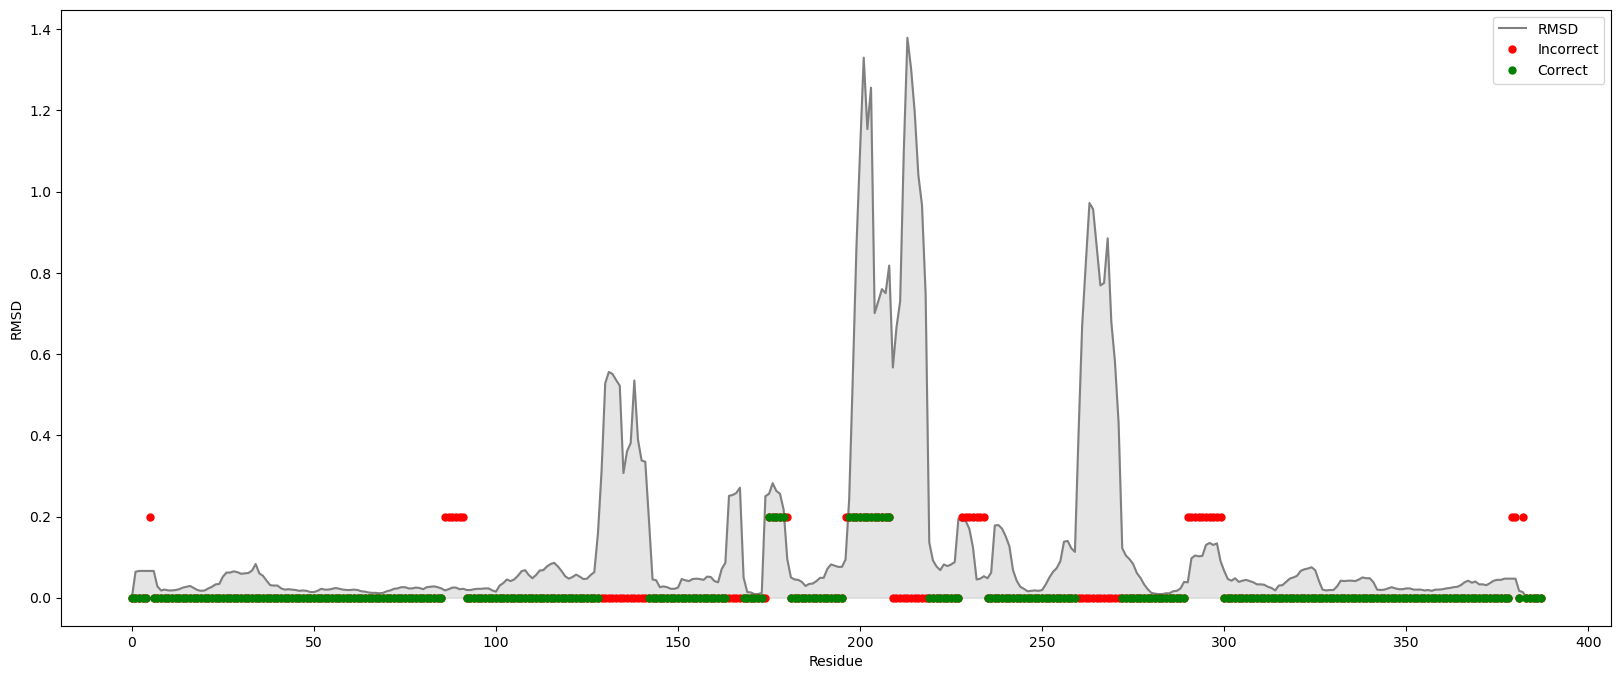

In [111]:
def plot_predictions(model, test_dataset, device):
    model.eval()
    example = test_dataset[random.randint(0, len(test_dataset))]
    with torch.no_grad():
        # Create tensors from the examples
        inputs = example[0].unsqueeze(0).to(device)
        labels = example[1].unsqueeze(0).to(device)
        rmsd = example[2].unsqueeze(0).to(device)
        # Remove the residues in rmsd that have a value of -1
        rmsd = rmsd[rmsd != -1]
        labels = labels[0, :rmsd.shape[0]]*RMSD_THRESHOLD
        outputs = model(inputs)
        outputs = torch.round(outputs)*RMSD_THRESHOLD
        outputs = outputs[:rmsd.shape[0]]

    rmsd, labels, outputs = rmsd.cpu().numpy(), labels.cpu().numpy(), outputs.cpu().numpy()

    # Get a list of correctly predicted labels
    correctly_predicted_labels = []
    for i in range(outputs.shape[0]):
        if outputs[i] == labels[i]:
            correctly_predicted_labels.append(outputs[i])
        else:
            correctly_predicted_labels.append(None)

    print(correctly_predicted_labels[:15])
    print(outputs[:15])
    print(labels[:15])


    # Plot the RMSD values
    plt.figure(figsize=(20, 8))
    plt.plot(rmsd, label='RMSD', color='gray')
    plt.fill_between(range(len(rmsd)), rmsd, color='gray', alpha=0.2)
    plt.plot(outputs, label='Incorrect', marker='o', linestyle='', markersize=5, color='red')
    plt.plot(correctly_predicted_labels, label='Correct', marker='o', linestyle='', markersize=5, color='green')
    plt.xlabel('Residue')
    plt.ylabel('RMSD')
    plt.legend()
    plt.show()
    
    

plot_predictions(model, test_dataset, device)